# Image Segmentation using Oxford-IIIT Pets Dataset 
(www.robots.ox.ac.uk/~vgg/data/pets)

##### Downloading and uncompressing data

In [ ]:
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xf images.tar.gz
# !tar -xf annotations.tar.gz

In [ ]:
import os

# input file paths

input_dir = "images/"
target_dir = "annotations/trimaps"

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)

target_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

# Plot a sample
plt.axis("off")
plt.imshow(load_img(input_img_paths[8]))

# Plot a target
def display_target(target_array):
    """
    target_array: 1, 2, 3
    normalized_array: black/grey/white
    """
    normalized_array = (target_array.astype("uint8") - 1) * 127 
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])
    
plt.figure()
img = img_to_array(load_img(target_paths[8], color_mode="grayscale"))
display_target(img)

In [ ]:
# Split the data
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1984).shuffle(input_img_paths)
random.Random(1984).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale")
    )
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i]) 

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [ ]:
# Building a model
import keras
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

MaxPooling Layers worked best for classification tasks, however, we are using padding to decrease the feature map (by a factor of two with each layer with padding parameter set to two).

In [ ]:
# Compilation and Training steps
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "oxford_segmentation.keras",
        save_best_only=True
        )
]
history = model.fit(
    train_input_imgs, train_input_imgs,
    callbacks=callbacks,
    batch_size=64, 
    validation_data=(val_input_imgs, val_targets)
)

# Plot the training results
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(epochs, loss, "bo", label="train loss")
plt.plot(epochs, val_loss, "b", label="val loss")
plt.title("Train and Validation Performance")
plt.legend()

In [ ]:
from keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 9
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

# Deep Model Architechture 
how to structure deep models:
- use reapeated `blocks` of layers
- the number of `filters` should increase as the size of the `spatial feature maps` decreases
- `deep and narrow` is better than `broad and shallow`
- try including `residual connections`, `batch normalization`, `SeparableConv2D` in your model  

#### Residual Connections
where an input to the layers is added to the output so as to fight vanishing gradients

In [ ]:
# Residual blocks where the number of filters changes
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
residual = layers.Conv2D(64, 1)(residual)   # 32 features -> 64 features
x = layers.add([x, residual])

In [ ]:
# Residual blocks where it include MaxPooling layer
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", paddin="same")(inputs)
x = layers.MaxPooling2D(2, padding="same")(x)
residual = layers.Conv2D(64, 1, strides=2)(residual) # feed the layer outputs to itself
x = layers.add([x, residual])

In [ ]:
# One more example
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary() 

#### Batch Normalization
- A layer that changes output from the previous layer so that it has a mean of 0 and standard deviation of 1. 
- The previous layer doesn't need to have bias.
- It's (arguably) best that activation is applied after batch normalization (as output from activations like relu are non negative)

In [ ]:
x = layers.Conv2D(32, 3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

#### Depthwise Separable Convolutions
- they assume channels are uncorellated and therefore perform less computations and have fewer parameters.
- having fewer parameters means they are less prone to overfitting.
- yet, it's hard to see `speedup` because NVIDIA GPUs are highly optimized for standard convolutions not for SeparableConv2D

<p style="display:none">Francois Chollet was telling how it hurts when a researcher tries to drive from the common practices and he fails to persuade others even though his arguments make sense, because it is hard to change the entire ecosystem</p>

there is a cats and dogs classifier that makes use of this guidelines: Xception_like_DNN.ipynb

### Model Interpretation
- Convnet Intermediate Output (intermediate activation) Visualization
- Convnet Filter Visualization
- Class Activation Heatmap Visualization

In [1]:
import keras 

# load a previously trainad model (from the previous chapter)
model = keras.models.load_model("../ch8/convnet_from_scratch_with_augmentation.keras")
model.summary()

2024-07-12 08:37:28.440164: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-12 08:37:28.721683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 08:37:28.841672: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 08:37:28.842211: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-12 08:37:29.077582: I tensorflow/core/platform/cpu_feature_gua

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        82,945 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 942,724 (3.60 MB)

 Trainable params: 471,361 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 471,363 (1.80 MB)

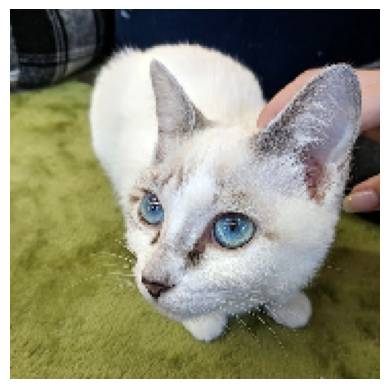

In [2]:
# Preprocessing a single image not in the training set
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg"
)

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, 
        target_size=target_size
    )
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

# display the image
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

#### Instantiate a model that will return outputs of intermediate layers

In [3]:
from keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [23]:
# using the model to compute layer activations
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0] # first conv layer activation for the cat image
first_layer_activation.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


(1, 178, 178, 32)

#### Intermediate Output Visualization

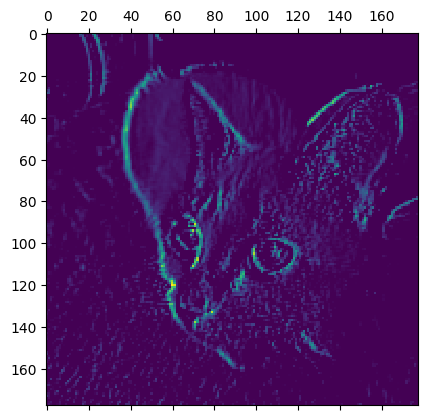

In [43]:
# Visualising the first convolution layer for the cat image
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

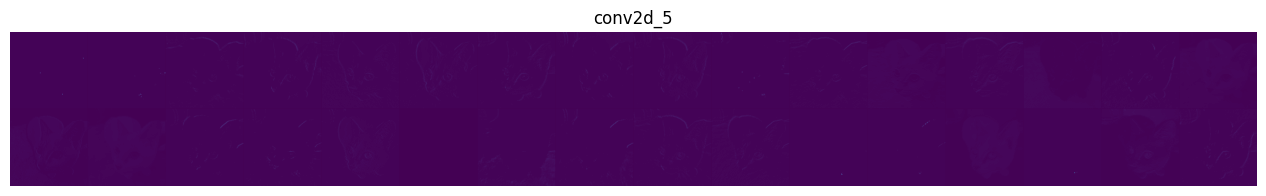

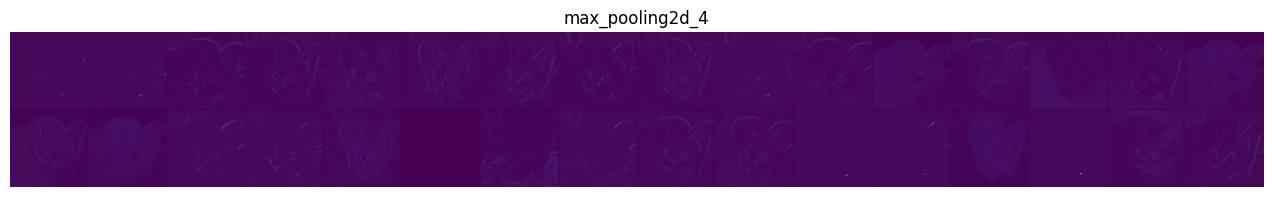

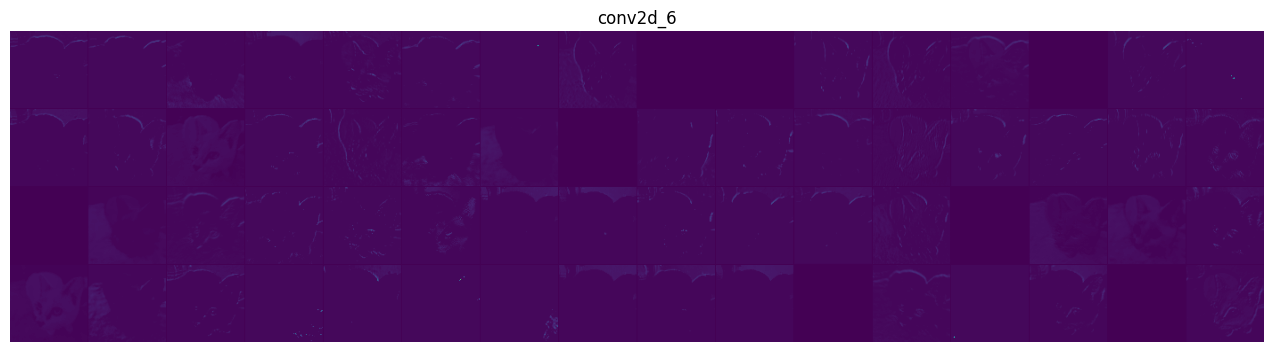

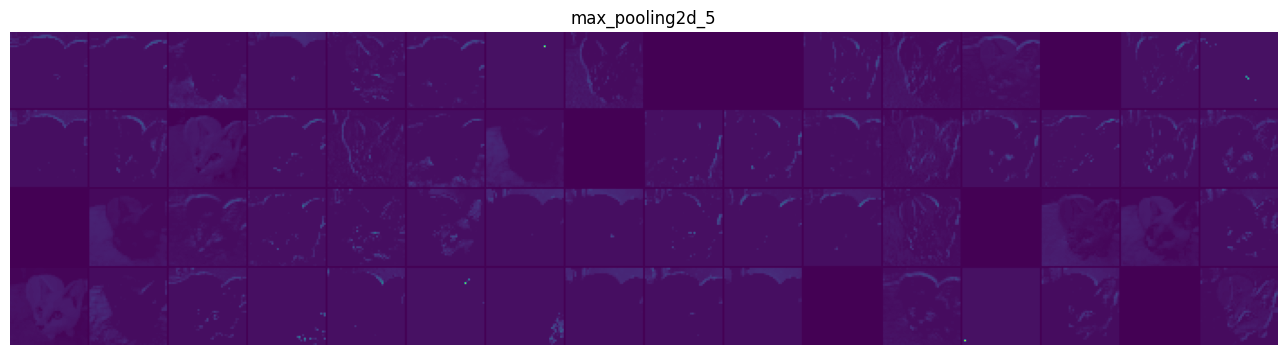

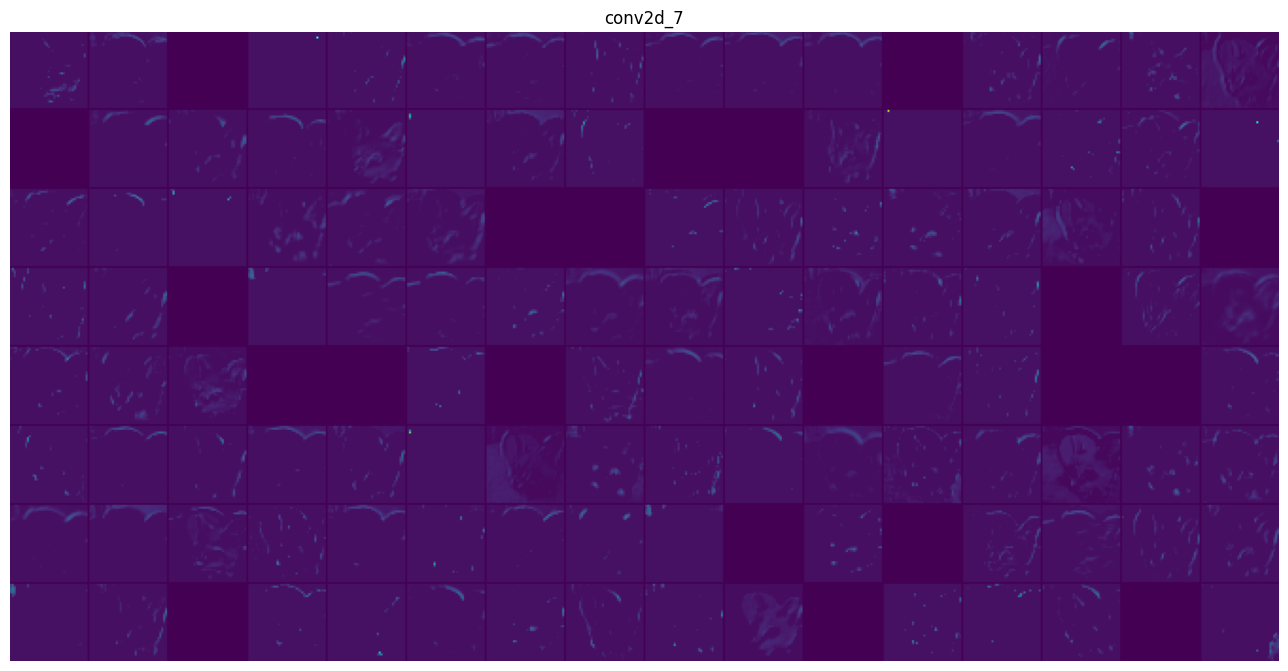

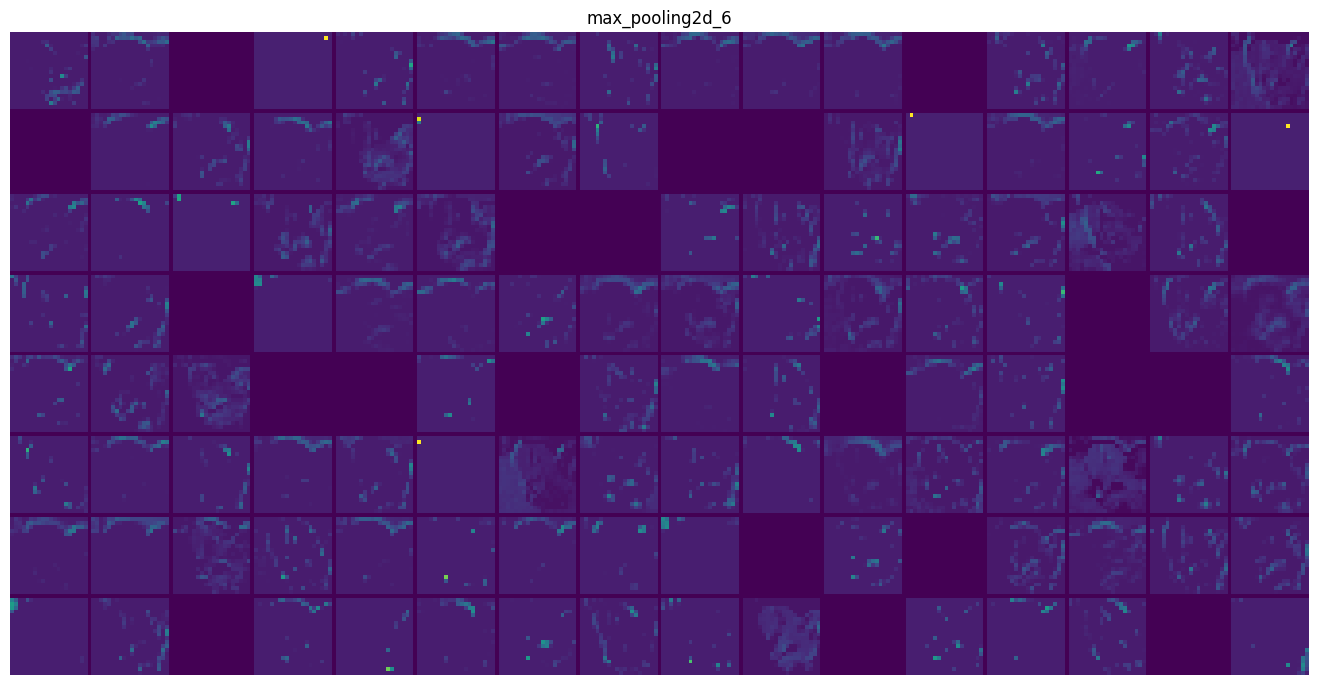

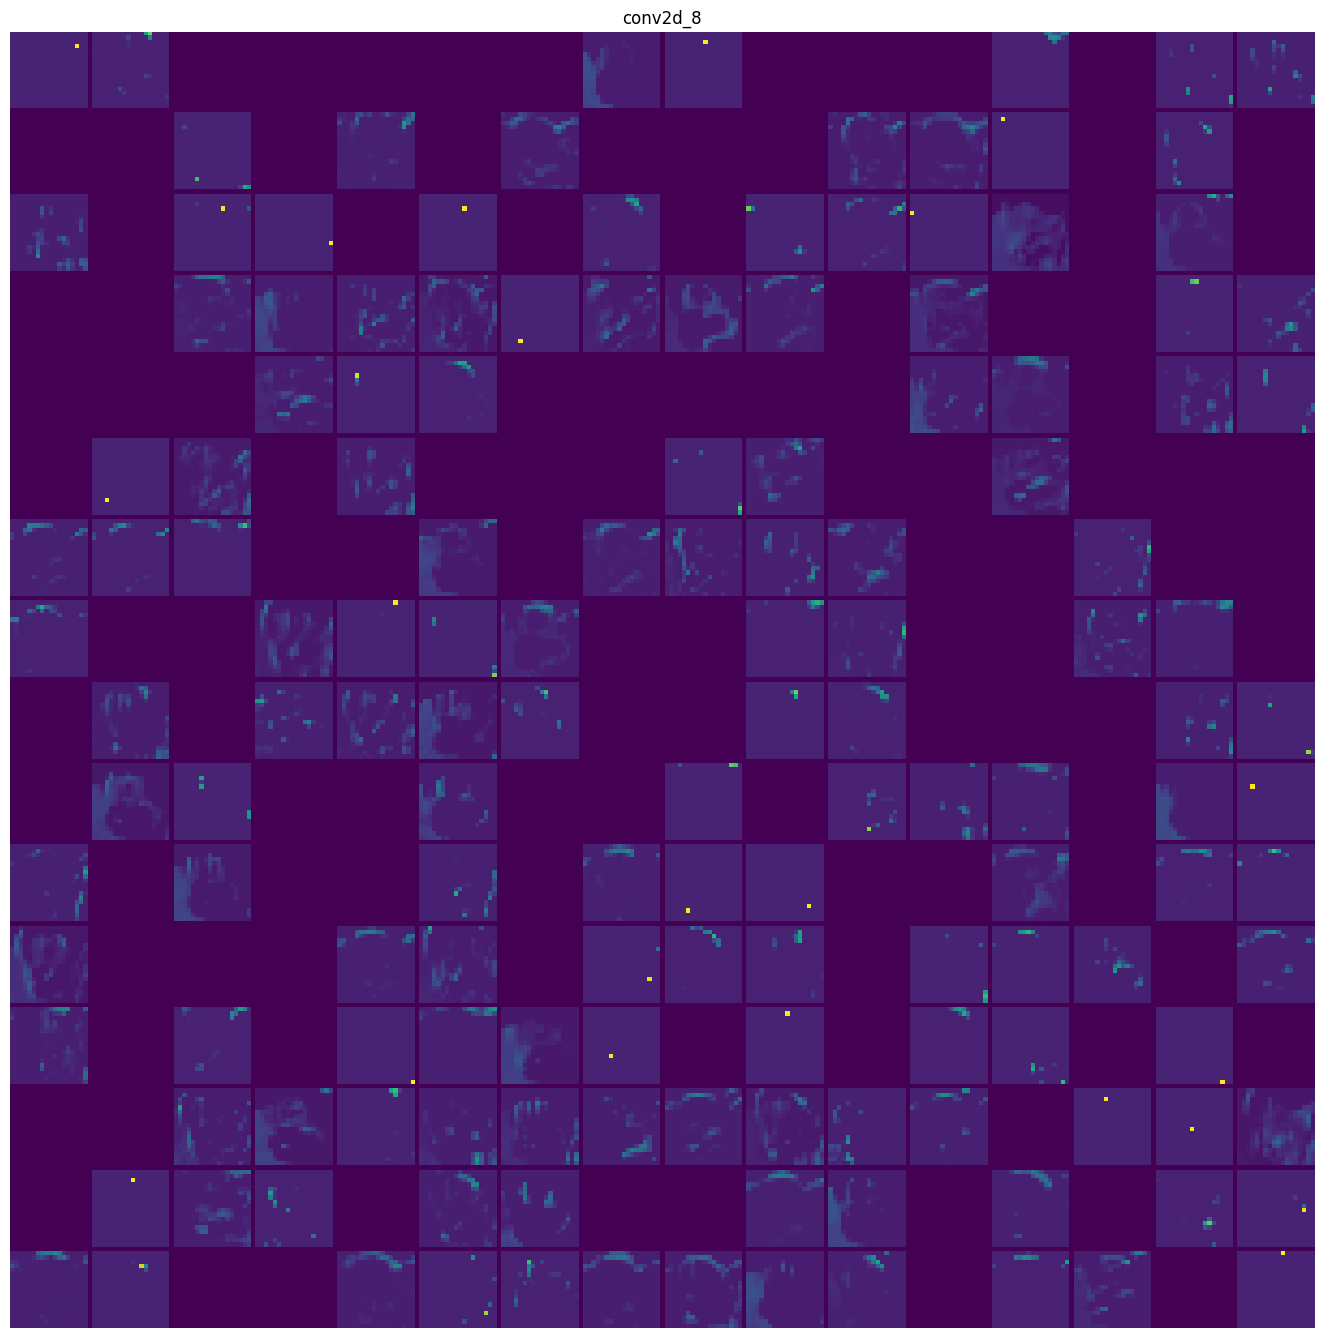

In [42]:
# Visualization every channel

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(
        [
            (size + 1) * n_cols - 1,
            images_per_row * (size + 1) - 1
        ]
        )
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128

            display_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1) : (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row   
            ] = channel_image
    scale = 1. / size
    plt.figure(
        figsize=(scale * display_grid.shape[1],
                 scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

- the initial layers are almost all full (as these features are similar to edges etc.)
- the outputs become less interpretable as they start encoding things that are abstract and related to the class not the visual characteristic like eyeline etc (maybe like the existence of two eyes for example).
- the last layer visualization has many empty squares which means those features are not found directly in the image


#### Visualizing convnet filters
`gradient ascent in input space`: gradient descent is applied to the value of the input image to maximize the response of a filter starting from a blank input image 

In [81]:
# Load Conv base
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False
)

In [82]:
# names of layers
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d_8
block3_sepconv1
block3_sepconv2
conv2d_9
block4_sepconv1
block4_sepconv2
conv2d_10
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_11
block14_sepconv1
block14_sepconv2


In [83]:
# Creating a feature extractor model
layer_name = "block6_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

# using the feature extractor
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

# gradient ascent's loss function
import tensorflow as tf

def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index] # conv layers produce border artifacts
    return tf.reduce_mean(filter_activation)

# Notes:
`model(x)` is used when gradients are needed while `model.predict(x)` can scale to large arrays     

In [84]:
# Gradient Asscent
# Loss Maximization via Stochastic Gradient Ascent
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image) # since it's not tf.variable
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads 
    return image

# putting it all into a function
img_width = 200
img_height = 200
def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3)
    )
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

# The result image tensor is a floating-point array of shape (200, 200, 3).
# Post processing is needed to convert it into [0, 255] range

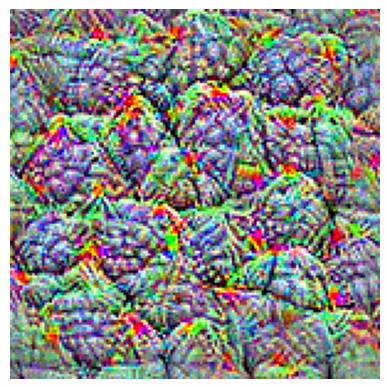

In [85]:
# Tensor to image utility function
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :] # avoid border artifacts
    return image 

plt.axis("off") 
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=10))) # it looks like this layer is detecting face of cats

In [86]:
# generating a list of all filter response patterns in a layer
all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5 # blank canvas for
n = 8
cropped_width = img_width - 25*2
cropped_height = img_height - 25*2
width = n * cropped_width + (n-1) * margin
height = n * cropped_height + (n-1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i*n + j]

        row_start = (cropped_width + margin) * i
        row_end = (cropped_width + margin) * i + cropped_width
        column_start = (cropped_height + margin) * j
        column_end = (cropped_height + margin) * j + cropped_height

        stitched_filters[
            row_start : row_end,
            column_start : column_end,
            :
        ] = image

keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png",
    stitched_filters
)




Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

#### Visualizing Heatmaps of class activation
Grad-CAM: (maybe incorrect but this is what I understood) Produces heatmaps of how much cat-like or dog-like different part of the image are

In [87]:
# load the full xception model
model = keras.applications.xception.Xception(weights="imagenet")

# preprocessing and image of two elephants
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg"
)

# convert to numpy array of float32, preprocess 
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0) # batch size of 1. (299, 299, 3) -> (1, 299, 299, 3)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299)) # (299, 299) xception input image size

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 53s 1us/step
733657/733657 ━━━━━━━━━━━━━━━━━━━━ 1s 2us/step


In [88]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step 
[('n02504458', 'African_elephant', 0.8699394), ('n01871265', 'tusker', 0.07695638), ('n02504013', 'Indian_elephant', 0.02354179)]


In [89]:
# Grad-CAM to see which parts are the most African-elephant-like
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions"
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

# map the last conv layer outputs to the final class predictions
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

# Retrieving gradients of the top predicted class
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output) # gradient of the top predicted class with respect to 
                                                                # the output feature map of the last convolutional layer

In [90]:
# Gradient pooling and channel-importance weighting
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i] # multiply each channel by its importance
heatmap = np.mean(last_conv_layer_output, axis=-1)

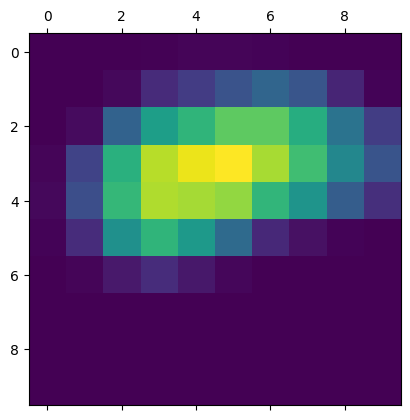

In [91]:
# Heatmap post-processing
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [103]:
# Superimposing the heatmap on the original image
import matplotlib.pyplot as plt

# load the original image
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap) # rescale to 0-255

jet = plt.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)